# Dynamical Magnetic Xray Scattering

In this example static and transient magnetic X-ray simulations are carried out employing a dynamical magnetic X-ray scattering formalism which was adapdet from [Project Dyna](https://neel.cnrs.frspip.php/?rubrique1008).

## Setup

Do all necessary imports and settings.

In [139]:
%load_ext autoreload
%autoreload 2
import udkm1Dsim as ud
u = ud.u #  import the pint unit registry from udkm1Dsim
import scipy.constants as constants
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib() #  use matplotlib with pint units

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Structure

Refere to the [structure-example](structure.ipynb) for more details.

In this example the sample `Structure` consists of `AmorphousLayer`s.

In order to build an antiferromagntic sample two different types of _Fe_ `Atom`s and `AmorphousLayer`s are created with opposite in-plane magnetization.

Here a local file for the atomic scattering factor is read only for Fe atoms.

In [140]:
Fe_right = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=90*u.deg,
                  atomic_form_factor_path='./Fe.cf')
Fe_left = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=270*u.deg,
                  atomic_form_factor_path='./Fe.cf')
Cr = ud.Atom('Cr')
Si = ud.Atom('Si')

In [141]:
density_Fe = 7874*u.kg/u.m**3

prop_Fe = {}
prop_Fe['heat_capacity'] = 449*u.J/u.kg/u.K
prop_Fe['therm_cond'] = 80*u.W/(u.m *u.K)
prop_Fe['lin_therm_exp'] = 11.8e-6
prop_Fe['sound_vel'] = 4.910*u.nm/u.ps
prop_Fe['opt_ref_index'] = 2.9174+3.3545j


layer_Fe_left = ud.AmorphousLayer('Fe_left', 'Fe left amorphous', 1*u.nm, density_Fe, atom=Fe_left, **prop_Fe)
layer_Fe_right = ud.AmorphousLayer('Fe_right', 'Fe right amorphous', 1*u.nm, density_Fe, atom=Fe_right, **prop_Fe)

In [142]:
density_Cr = 7140*u.kg/u.m**3

prop_Cr = {}
prop_Cr['heat_capacity'] = 449*u.J/u.kg/u.K
prop_Cr['therm_cond'] = 94*u.W/(u.m *u.K)
prop_Cr['lin_therm_exp'] = 6.2e-6
prop_Cr['sound_vel'] = 5.940*u.nm/u.ps
prop_Cr['opt_ref_index'] = 3.1612+3.4606j

layer_Cr = ud.AmorphousLayer('Cr', "Cr amorphous", 1*u.nm, density_Cr, atom=Cr, **prop_Cr)

In [143]:
density_Si = 2336*u.kg/u.m**3

prop_Si = {}
prop_Si['heat_capacity'] = 703*u.J/u.kg/u.K
prop_Si['therm_cond'] = 150*u.W/(u.m *u.K)
prop_Si['lin_therm_exp'] = 2.6e-6
prop_Si['sound_vel'] = 8.433*u.nm/u.ps
prop_Si['opt_ref_index'] = 3.6941+0.0065435j

layer_Si = ud.AmorphousLayer('Si', "Si amorphous", 1*u.nm, density_Si, atom=Si, **prop_Si)

In [144]:
S = ud.Structure('Fe/Cr AFM Super Lattice')

# create a sub-structure
DL = ud.Structure('Two Fe/Cr Double Layers')
DL.add_sub_structure(layer_Fe_left, 1)
DL.add_sub_structure(layer_Cr, 1)
DL.add_sub_structure(layer_Fe_right, 1)
DL.add_sub_structure(layer_Cr, 1)

S.add_sub_structure(DL, 10)
S.add_sub_structure(layer_Fe_left, 10)
S.add_sub_structure(layer_Si, 100)

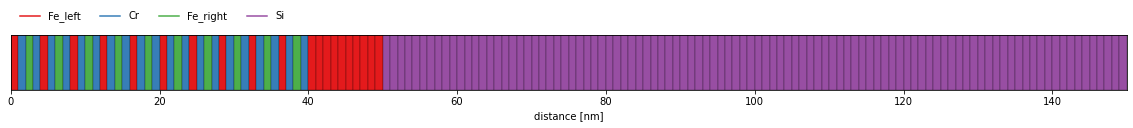

In [145]:
S.visualize()

## Heat

Refere to the [heat-example](heat.ipynb) for more details.

In [146]:
h = ud.Heat(S, True)

h.save_data = False
h.disp_messages = True

h.excitation = {'fluence': [10]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [0]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 45*u.deg}

# enable heat diffusion
h.heat_diffusion = True

# temporal and spatial grid
delays = np.r_[-1:20:0.1]*u.ps
_, _, distances = S.get_distances_of_layers()

In [147]:
temp_map, delta_temp_map = h.get_temp_map(delays, 300*u.K)

Elapsed time for _temperature_after_delta_excitation_: 0.040174 s
Calculating _heat_diffusion_ ...



Elapsed time for _heat_diffusion_: 11.671941 s
Elapsed time for _temp_map_: 11.734933 s


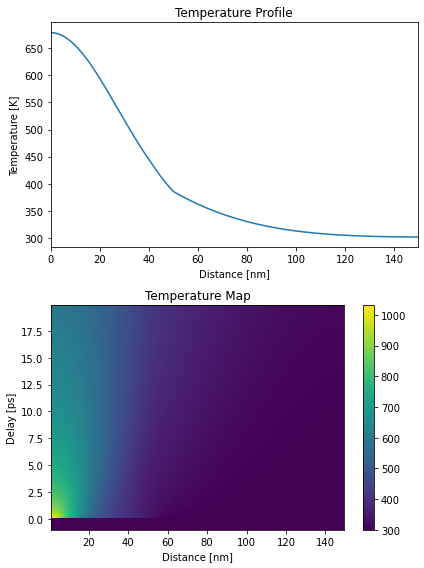

In [148]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, temp_map[101, :])
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Temperature [K]')
plt.title('Temperature Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map')

plt.tight_layout()
plt.show()

## Numerical Phonons

Refere to the [phonons-example](phonons.ipynb) for more details.

In [11]:
p = ud.PhononNum(S, True)
p.save_data = False
p.disp_messages = True

In [12]:
strain_map = p.get_strain_map(delays, temp_map, delta_temp_map)

Calculating linear thermal expansion ...
Calculating coherent dynamics with ODE solver ...



Elapsed time for _strain_map_: 0.655711 s


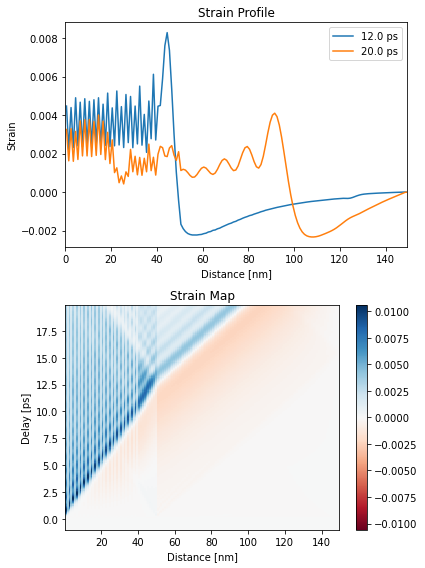

In [13]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, strain_map[130, :], label=np.round(delays[130]))
plt.plot(distances.to('nm').magnitude, strain_map[-1, :], label=np.round(delays[-1]))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Strain')
plt.legend()
plt.title('Strain Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude,
               strain_map, cmap='RdBu',
               vmin=-np.max(strain_map), vmax=np.max(strain_map))
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Strain Map')

plt.tight_layout()
plt.show()

## Initialize dynamical magnetic X-ray simulations

The `XrayDynMag` class requires a `Structure` object and a boolean `force_recalc` in order overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can using the boolean switch `progress_bar`.

In [149]:
dyn_mag = ud.XrayDynMag(S, True)
dyn_mag.disp_messages = True
dyn_mag.save_data = False

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized


## Homogeneous magnetic X-ray scattering

For the case of homogeneously strained/magnetized samples, the dynamical magnetic X-ray scattering simulations can be greatly simplyfied, which saves a lot of computational time.

### $q_z$-scan

The `XrayDynMag` object requires an `energy` and scattering vector `qz` to run the simulations.  
Both parameters can be arrays and the resulting reflectivity has a first dimension for the photon energy and the a second for the scattering vector.

The resulting reflectivity is always calculated for the actual magnetization (`R_hom`) of the sample, as well as for opposite magnetization (`R_hom_phi`).

In [150]:
dyn_mag.energy = np.r_[600, 710]*u.eV #  set two photon energies
dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range

R_hom, R_hom_phi = dyn_mag.homogeneous_reflectivity() #  this is the actual calculation

Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.369520 s


In this example half-order antiferromagnetic Bragg peaks appear only at the resonance.

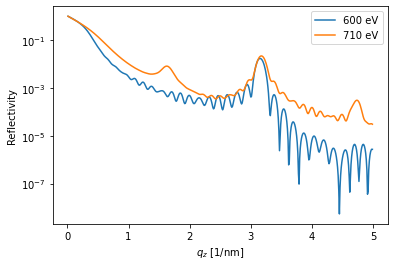

In [151]:
plt.figure()
plt.semilogy(dyn_mag.qz[0, :], R_hom[0, :], label='{}'.format(dyn_mag.energy[0]))
plt.semilogy(dyn_mag.qz[1, :], R_hom[1, :], label='{}'.format(dyn_mag.energy[1]))
plt.ylabel('Reflectivity')
plt.xlabel(r'$q_z$ [1/nm]')
plt.legend()
plt.show()

### Post-Processing

Simple convolution of the results with an arbitrary function handle.

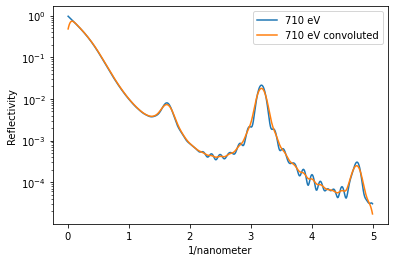

In [17]:
FWHM = 0.01/1e-10 # Angstrom
sigma = FWHM /2.3548
        
handle = lambda x: np.exp(-((x)/sigma)**2/2)
y_conv = dyn_mag.conv_with_function(R_hom[1,:], dyn_mag._qz[1,:], handle)

plt.figure()
plt.semilogy(dyn_mag.qz[0,:], R_hom[1,:], label='{}'.format(dyn_mag.energy[1]))
plt.semilogy(dyn_mag.qz[0,:], y_conv, label='{} convoluted'.format(dyn_mag.energy[1]))
plt.ylabel('Reflectivity')
plt.legend()
plt.show()

### Energy- and $q_z$-scan

In [18]:
dyn_mag.energy = np.r_[690:730:0.1]*u.eV #  set the energy range
dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm # qz range

R_hom, R_hom_phi = dyn_mag.homogeneous_reflectivity() #  this is the actual calculation

Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 59.993615 s


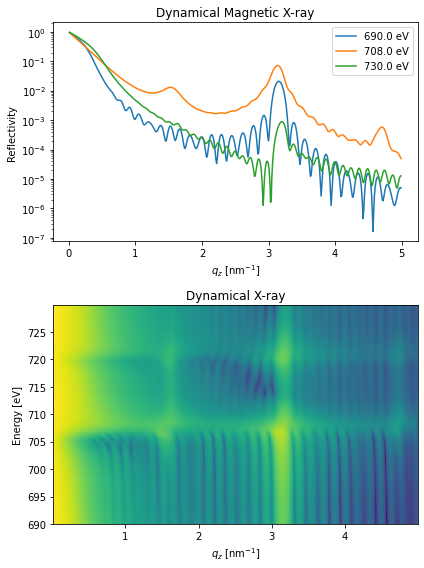

In [19]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_hom[0, :], label=np.round(dyn_mag.energy[0]))
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_hom[180, :], label=np.round(dyn_mag.energy[180]))
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_hom[-1, :], label=np.round(dyn_mag.energy[-1]))

plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.ylabel('Reflectivity')
plt.legend()
plt.title('Dynamical Magnetic X-ray')

plt.subplot(2, 1, 2)
plt.pcolormesh(dyn_mag.qz[0, :].to('1/nm').magnitude, dyn_mag.energy.magnitude, np.log10(R_hom[:, :]))
plt.title('Dynamical X-ray')
plt.ylabel('Energy [eV]')
plt.xlabel('$q_z$ [nm$^{-1}$]')

plt.tight_layout()
plt.show()

## Inhomogeneous dynamical magnetic X-ray scattering

The `inhomogeneous_reflectivity()` method allows to calculate the transient magnetic X-ray reflectivity according to a `strain_map` and/or `magnetization_map`.

In [35]:
dyn_mag.energy = np.r_[708]*u.eV #  set the energy range
dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm # qz range

In [38]:
R_seq, R_seq_phi = dyn_mag.inhomogeneous_reflectivity(strain_map = strain_map,
                                                      magnetization_map=magnetization_map,)

Calculating _inhomogeneous_reflectivity_ ...



Elapsed time for _inhomogeneous_reflectivity_: 364.755083 s


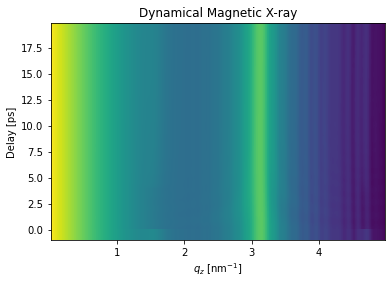

In [43]:
plt.figure()
plt.pcolormesh(dyn_mag.qz[0, :].to('1/nm').magnitude, delays.to('ps').magnitude, np.log10(R_seq[:, 0, :]))
plt.title('Dynamical Magnetic X-ray')
plt.ylabel('Delay [ps]')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.show()

In [46]:
dyn_mag.qz[0, 160]


1.61 <Unit('1 / nanometer')>

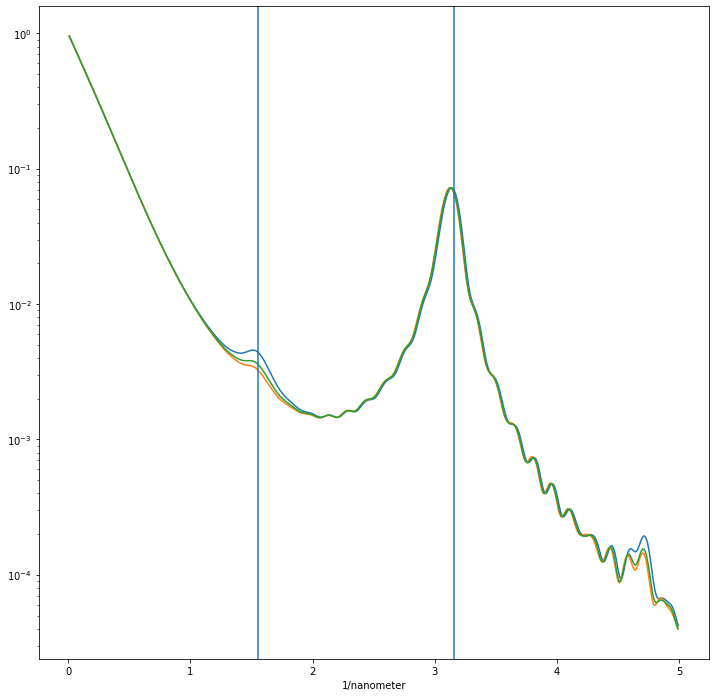

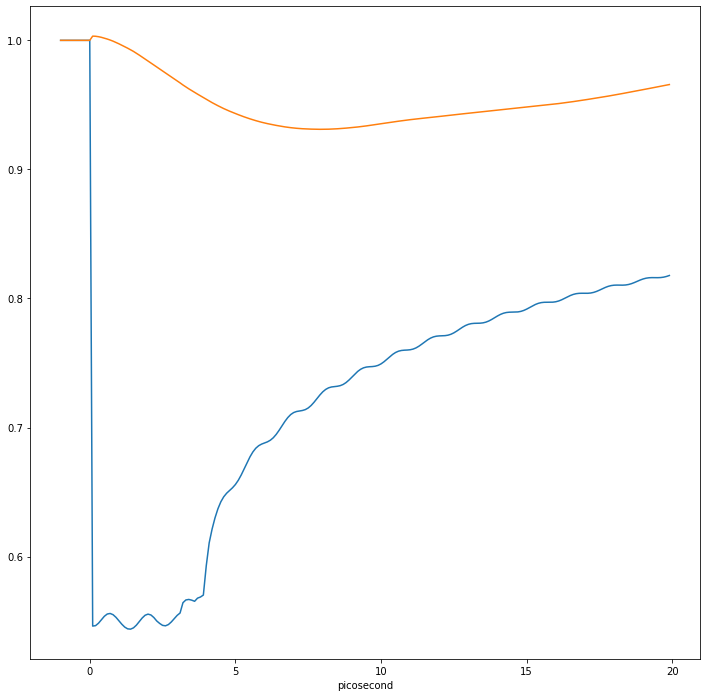

In [59]:
plt.figure(figsize=[12,12])
plt.semilogy(dyn_mag.qz[0,:], (R_seq[0, 0, :]))
plt.semilogy(dyn_mag.qz[0,:], (R_seq[100, 0, :]))
plt.semilogy(dyn_mag.qz[0,:], (R_seq[200, 0, :]))

plt.axvline(dyn_mag.qz[0, 154])
plt.axvline(dyn_mag.qz[0, 315])
plt.show()

plt.figure(figsize=[12,12])
plt.plot(delays, R_seq[:, 0, 154]/R_seq[0, 0, 154])
plt.plot(delays, R_seq[:, 0, 315]/R_seq[0, 0, 315])
plt.show()

## Magnetization

The `Magnetization` class is currently only an interface to allow the user for defining specific magnetization dynamics depending on the `strain_map` and `temp_map`.

Here the magnetization as function of tmeperatrue is used as a simplified model to alter the transient magnetization amplitude.

c:\users\schick\general\python\wpy64-3770\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


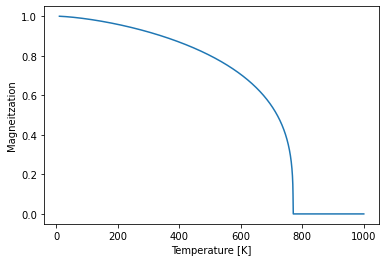

In [19]:
def magnetization_cuire(x,Tc, M0, beta):
    m = M0*((1-(x/Tc)**(3/2))**beta)*np.heaviside(Tc-x, 0.5)
    m[np.isnan(m)] = 0
    return m

plt.figure()
temperatures = np.r_[10:1000:0.1]
plt.plot(temperatures, magnetization_cuire(temperatures, 770, 1, .3))
plt.xlabel('Temperature [K]')
plt.ylabel('Magneitzation')
plt.show()

The `calc_magnetization_map` method must be overwritten to allow for calculating magnetization dynamics.

In [20]:
class SimpleMagnetization(ud.Magnetization):

    def calc_magnetization_map(self, delays, **kwargs):
        strain_map = kwargs['strain_map']
        temp_map = kwargs['temp_map']
        T_c = kwargs['T_c']
        magnetization_map = np.zeros([len(delays), self.S.get_number_of_layers(), 3])
        
        handles = self.S.get_layer_vectors()[2]
        
        for i, handle in enumerate(handles):
            if handle.id in ['Fe_left', 'Fe_right']:
                magnetization_map[:, i, 0] = magnetization_cuire(temp_map[:, i], T_c, 1, .3)
        
            magnetization_map[:, i, 1] = handle.magnetization['phi']
            magnetization_map[:, i, 2] = handle.magnetization['gamma']
        
        return magnetization_map

In [21]:
mag = SimpleMagnetization(S, True)
mag.save_data = False

magnetization_map = mag.get_magnetization_map(delays, strain_map = strain_map, temp_map = temp_map, T_c = 770)

Calculating _magnetization_map_ ...
Elapsed time for _magnetization_map_: 0.006943 s


c:\users\schick\general\python\wpy64-3770\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
c:\users\schick\general\python\wpy64-3770\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:15: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  from ipykernel import kernelapp as app
c:\users\schick\general\python\wpy64-3770\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:16: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  app.launch_new_instance()


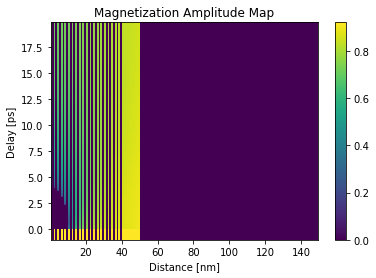

In [22]:
plt.figure()
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map[:, :, 0])
plt.title('Magnetization Amplitude Map')
plt.ylabel('Delay [ps]')
plt.xlabel('Distance [nm]')
plt.colorbar()
plt.show()

## Parallel dynamical Xray scattering

Parallelization needs still to be implemented, but will work similarly as with XrayDyn.

You need to install the `udkm1Dsim` with the `parallel` option which essentially add the Dask package to the requirements:

```
> pip install udkm1Dsim[parallel]
```

You can also install/add Dask manually, e.g. via pip:

```
> pip install dask
```

Please refer to the [Dask documentation](https://docs.dask.org/en/latest/) for more details on parallel computing in Python.


In [31]:
from dask.distributed import Client
client = Client()

In [32]:
client

<Client: 'tcp://127.0.0.1:57089' processes=4 threads=4, memory=17.02 GB>


In [33]:
R_seq, R_seq_phi = dyn_mag.inhomogeneous_reflectivity(strain_map=strain_map,
                                                      magnetization_map=magnetization_map,
                                                      calc_type='parallel', dask_client=client)

Calculating _inhomogeneous_reflectivity_ ...


distributed.utils - ERROR - '<' not supported between instances of 'NoneType' and 'tuple'
Traceback (most recent call last):
  File "c:\users\schick\general\python\wpy64-3770\python-3.7.7.amd64\lib\site-packages\distributed\utils.py", line 665, in log_errors
    yield
  File "c:\users\schick\general\python\wpy64-3770\python-3.7.7.amd64\lib\site-packages\distributed\dashboard\components\scheduler.py", line 1842, in individual_graph_doc
    graph = TaskGraph(scheduler, sizing_mode="stretch_both")
  File "c:\users\schick\general\python\wpy64-3770\python-3.7.7.amd64\lib\site-packages\distributed\dashboard\components\scheduler.py", line 1123, in __init__
    self.layout = GraphLayout(scheduler)
  File "c:\users\schick\general\python\wpy64-3770\python-3.7.7.amd64\lib\site-packages\distributed\diagnostics\graph_layout.py", line 39, in __init__
    self.scheduler, dependencies=dependencies, priority=priority
  File "c:\users\schick\general\python\wpy64-3770\python-3.7.7.amd64\lib\site-packages

Elapsed time for _inhomogeneous_reflectivity_: 248.209275 s


In [30]:
client.close()

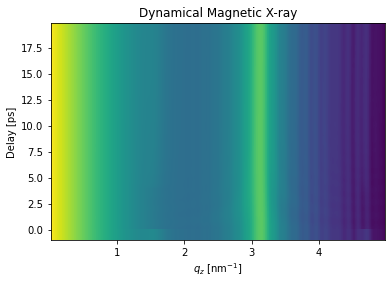

In [34]:
plt.figure()
plt.pcolormesh(dyn_mag.qz[0, :].to('1/nm').magnitude, delays.to('ps').magnitude, np.log10(R_seq[:, 0, :]))
plt.title('Dynamical Magnetic X-ray')
plt.ylabel('Delay [ps]')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.show()

## Polarization Dependence

### Non-Magnetic sample

The current sample is currently not magnetic, therefore, there should no scattering from sigma to pi and vice versa.

In [23]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(3, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> sigma'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> pi'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('non-magnetic sample: sigma')
plt.legend()
plt.show()

NameError: name 'mag' is not defined

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(4, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> pi'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> sigma'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('non-magnetic sample: pi')
plt.legend()
plt.show()

### Magnetic Sample

Now compare the scattering with a ferromagnetic and antiferromagnetic sample structure.

In [ ]:
# Fe atom with magnetization in-plane to the left
Fe_left = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=90*u.deg, id='Fe left')
# Fe atom with magnetization in-plane to the right
Fe_right = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=270*u.deg, id='Fe right')

# Fe unit cell with left in-plane magnetization
Fe_uc_left = ud.UnitCell('Fe_left', 'Fe', c_Fe, **propFe)
Fe_uc_left.add_atom(Fe_left, 0)
Fe_uc_left.add_atom(Fe_left, 0.5)

# Fe unit cell with right in-plane magnetization
Fe_uc_right = ud.UnitCell('Fe_right', 'Fe', c_Fe, **propFe)
Fe_uc_right.add_atom(Fe_right, 0)
Fe_uc_right.add_atom(Fe_right, 0.5)

#### FM Sample

In [ ]:
N_Fe = 5
N_Cr = 4

SFM = ud.Structure('FM Super Lattice')

DLFM = ud.Structure('FM Double Layer Fe+Cr')
DLFM.add_sub_structure(Fe_uc_left, N_Fe)
DLFM.add_sub_structure(Cr_uc, N_Cr)

SFM.add_sub_structure(DLFM, 20)

# add Si substrate
SFM.add_substrate(substrate)

distances, _, _ = SFM.get_distances_of_layers() # distance vector of all unit cells

mag.S = SFM # replace the sample in the current simulation

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(3, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> sigma'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> pi'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: sigma')
plt.legend()
plt.show()

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(4, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> pi'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> sigma'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: pi')
plt.legend()
plt.show()

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(1, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ +'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(2, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ -'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: circular')
plt.legend()
plt.show()

Same again with the non-magnetic sample

In [ ]:
mag.S = S # change again to the inital sample

mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(1, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ +'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(2, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ -'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('FM sample: circular')
plt.legend()
plt.show()

#### AFM Sample

In [ ]:
N_Fe = 5
N_Cr = 4

SAFM = ud.Structure('AFM Super Lattice')

DLAFM = ud.Structure('AFM Double Layer Fe+Cr')
DLAFM.add_sub_structure(Fe_uc_left, N_Fe)
DLAFM.add_sub_structure(Cr_uc, N_Cr)
DLAFM.add_sub_structure(Fe_uc_right, N_Fe)
DLAFM.add_sub_structure(Cr_uc, N_Cr)

SAFM.add_sub_structure(DLAFM, 10)

# add Si substrate
SAFM.add_substrate(substrate)

distances, _, _ = SAFM.get_distances_of_layers() # distance vector of all unit cells

mag.S = SAFM # replace the sample in the current simulation

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()

mag.set_polarization(3, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> unpolarized'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> sigma'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(3, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: sigma -> pi'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('AFM sample: sigma')
plt.legend()
plt.show()

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()

mag.set_polarization(4, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> unpolarized'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 4)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> pi'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(4, 3)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: pi -> sigma'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('AFM sample: pi')
plt.legend()
plt.show()

In [ ]:
mag.energy = np.r_[710]*u.eV #  set two photon energies
mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range


plt.figure()
mag.set_polarization(1, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ +'.format(mag.energy[0]), alpha=0.5)

mag.set_polarization(2, 0)
R_hom, R_hom_phi = mag.homogeneous_reflectivity() #  this is the actual calculation
plt.semilogy(mag.qz[0, :], R_hom[0, :], label='{}: circ -'.format(mag.energy[0]), alpha=0.5)

plt.ylabel('Reflectivity')
plt.title('AFM sample: circular')
plt.legend()
plt.show()

# Some Test

In [60]:
O = ud.Atom('O')
Mg = ud.Atom('Mg')
Al = ud.Atom('Al')

In [108]:
density_Al = 3580*u.kg/u.m**3

prop_Al = {}
prop_Al['heat_capacity'] = 897*u.J/u.kg/u.K
prop_Al['therm_cond'] = 235*u.W/(u.m *u.K)
prop_Al['lin_therm_exp'] = 24e-6
prop_Al['sound_vel'] = 6.3*u.nm/u.ps
prop_Al['opt_ref_index'] = 2.7673+8.354j

layer_Al = ud.AmorphousLayer('Al', "Al amorphous", 0.2*u.nm, density_Al, atom=Al, **prop_Al)

In [111]:
density_MgO = 2699*u.kg/u.m**3

prop_MgO = {}
prop_MgO['heat_capacity'] = 37*u.J/u.kg/u.K
prop_MgO['therm_cond'] = 50*u.W/(u.m *u.K)
prop_MgO['lin_therm_exp'] = 9e-6
prop_MgO['sound_vel'] = 6*u.nm/u.ps
prop_MgO['opt_ref_index'] = 1.7276+0j

MgO = ud.AtomMixed('MgO')
MgO.add_atom(Mg, 0.5)
MgO.add_atom(O, 0.5)

layer_MgO = ud.AmorphousLayer('MgO', "MgO amorphous", 0.2*u.nm, density_MgO, atom=MgO, **prop_MgO)

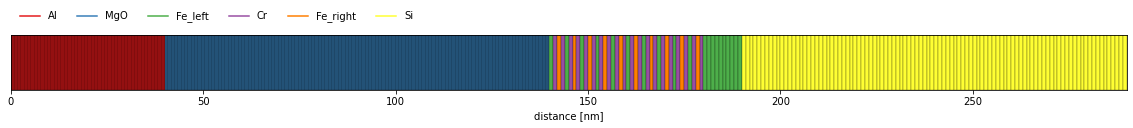

In [112]:
S_cap = ud.Structure('Fe/Cr AFM Super Lattice with Al cap')

S_cap.add_sub_structure(layer_Al, 5*40)
S_cap.add_sub_structure(layer_MgO, 5*100)
S_cap.add_sub_structure(DL, 10)
S_cap.add_sub_structure(layer_Fe_left, 10)
S_cap.add_sub_structure(layer_Si, 100)

S_cap.visualize()

In [155]:
h = ud.Heat(S_cap, True)

h.save_data = False
h.disp_messages = True

h.excitation = {'fluence': [10]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [0]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 45*u.deg}

# enable heat diffusion
h.heat_diffusion = False

# temporal and spatial grid
delays = np.r_[-1:50:0.1]*u.ps
_, _, distances = S_cap.get_distances_of_layers()

In [156]:
temp_map, delta_temp_map = h.get_temp_map(delays, 300*u.K)

Elapsed time for _temperature_after_delta_excitation_: 0.042656 s
Elapsed time for _temp_map_: 0.091264 s


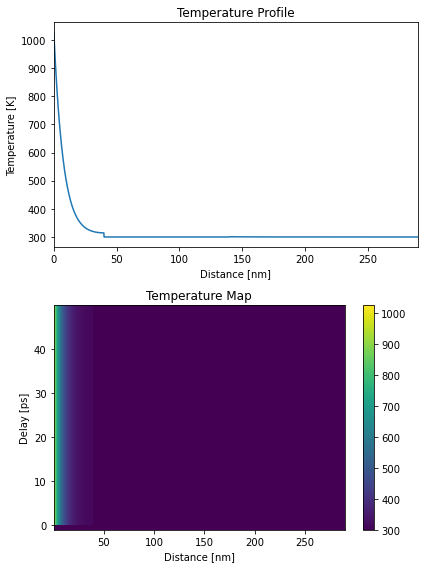

In [157]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, temp_map[101, :])
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Temperature [K]')
plt.title('Temperature Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map')

plt.tight_layout()
plt.show()

In [158]:
p = ud.PhononNum(S_cap, True)
p.save_data = False
p.disp_messages = True

In [159]:
strain_map = p.get_strain_map(delays, temp_map, delta_temp_map)

Calculating linear thermal expansion ...
Calculating coherent dynamics with ODE solver ...



Elapsed time for _strain_map_: 2.704184 s


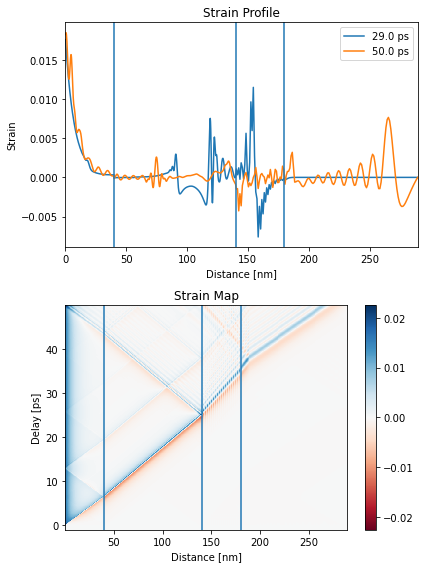

In [164]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, strain_map[300, :], label=np.round(delays[300]))
plt.plot(distances.to('nm').magnitude, strain_map[-1, :], label=np.round(delays[-1]))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Strain')
plt.axvline(40)
plt.axvline(40+100)
plt.axvline(40+100+40)

plt.legend()
plt.title('Strain Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude,
               strain_map, cmap='RdBu',
               vmin=-np.max(strain_map), vmax=np.max(strain_map))
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Strain Map')
plt.axvline(40)
plt.axvline(40+100)
plt.axvline(40+100+40)
plt.tight_layout()
plt.show()

In [152]:
dyn_mag = ud.XrayDynMag(S_cap, True)
dyn_mag.disp_messages = True
dyn_mag.save_data = False
dyn_mag.energy = np.r_[600, 710]*u.eV #  set two photon energies
dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm #  qz range

R_hom_cap, R_hom_phi_cap = dyn_mag.homogeneous_reflectivity() #  this is the actual calculation

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.626448 s


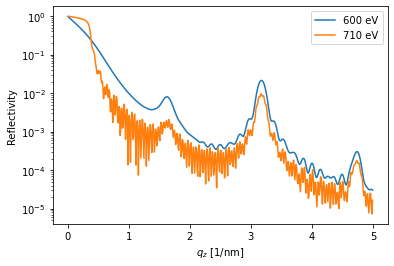

In [153]:
plt.figure()
plt.semilogy(dyn_mag.qz[0, :], R_hom[1, :], label='{}'.format(dyn_mag.energy[0]))
plt.semilogy(dyn_mag.qz[1, :], R_hom_cap[1, :], label='{}'.format(dyn_mag.energy[1]))
plt.ylabel('Reflectivity')
plt.xlabel(r'$q_z$ [1/nm]')
plt.legend()
plt.show()

In [ ]:
R_seq, R_seq_phi = dyn_mag.inhomogeneous_reflectivity(strain_map = strain_map)

Calculating _inhomogeneous_reflectivity_ ...
